<a href="https://colab.research.google.com/github/Weff24/PrivacyPlate/blob/main/pp_blur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Extraction from XML Files

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')


Mounted at /content/drive


In [114]:
import xml.etree.ElementTree as ET
import os
import sys
from collections import defaultdict

from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

from PIL import Image

In [115]:
# !pip install kornia

In [116]:
# import kornia

# 1. Test XML Data Extraction: License Plate Crop Borders

In [117]:
# Path to annotation folder
annot_dir_path = Path("/content/drive/MyDrive/01-License Plates/annotations")

if not annot_dir_path.exists():
  print("Annotation directory path does not exist")
  sys.exit(1)

# Extract the box from xml files
box_locations = defaultdict(list)
box_sizes = defaultdict(list)
box_elements = ['xmin', 'ymin', "xmax", "ymax"] # order of the box location
box_size_elements = ['width', 'height'] # order of image size

for path in os.listdir(annot_dir_path):
    tree = ET.parse(f'{annot_dir_path}/{path}')  # Replace 'your_xml_file.xml' with your XML file path
    root = tree.getroot()

    # Get key from XML
    xml_ind =int(path[4:-4])

    for element in box_elements:
        box_locations[xml_ind].append(int(root.find('object').find('bndbox').find(element).text))

    for element in box_size_elements:
        box_sizes[xml_ind].append(int(root.find('size').find(element).text))

max_w = 0
max_h = 0
for w, h in box_sizes.values():
    if max_w < w:
        max_w = w
    if max_h < h:
        max_h = h

print('Max Width = ', max_w)
print('Max Height = ', max_h)

Max Width =  600
Max Height =  531


# 2. Test License Plate Image Data Import

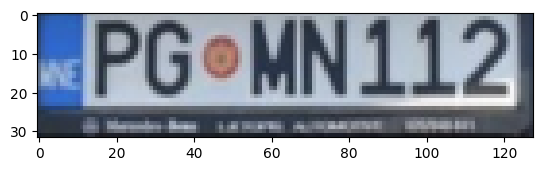

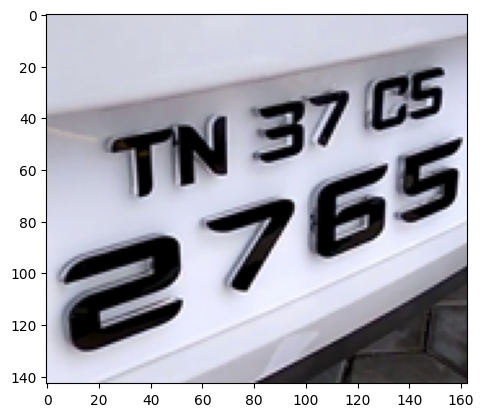

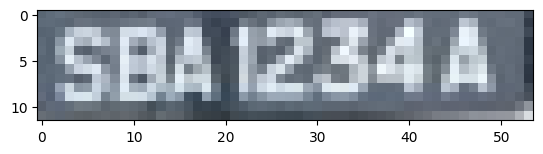

In [179]:
%matplotlib inline

img_dir_path = Path("/content/drive/MyDrive/01-License Plates/paddedimages")

if not img_dir_path.exists():
  print("Image directory path does not exist")
  sys.exit(1)

cropped_plate_images = []
plate_images = []

i = 0
for i, path in enumerate(os.listdir(img_dir_path)):
  plate_image = mpimg.imread(f"{img_dir_path}/{path}")
  fig, ax = plt.subplots()

  box = box_locations[int(path[4:-4])]
  cropped_plate_image = plate_image[box[1]:box[3], box[0]:box[2]]

  ax.imshow(cropped_plate_image)
#   plt.axis("off")
#   plt.savefig("/content/drive/MyDrive/01-License Plates/croppedimages/test.png")
  plt.show()

  plate_images.append((plate_image, box))
  cropped_plate_images.append((cropped_plate_image, box))

  i += 1
  if i == 3:
    break

In [180]:
plt.close()

In [181]:
# Round up to nearest odd integer for kernel size
def to_nearest_odd(n):
    if n % 2 == 0:
        return n + 1
    return n

[5, 25]
[5, 23]
[5, 21]
[5, 17]
[5, 15]
[5, 11]
[5, 9]
[5, 5]
[5, 3]
[5, 1]
[5, 33]
[5, 29]
[5, 25]
[5, 21]
[5, 19]
[5, 15]
[5, 11]
[5, 7]
[5, 3]
[5, 1]
[5, 11]
[5, 9]
[5, 9]
[5, 7]
[5, 7]
[5, 5]
[5, 3]


<ipython-input-188-406cc94d522f>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


[5, 3]
[5, 1]
[5, 1]


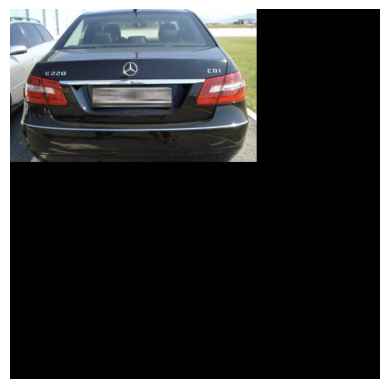

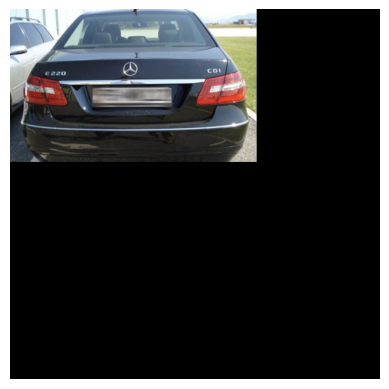

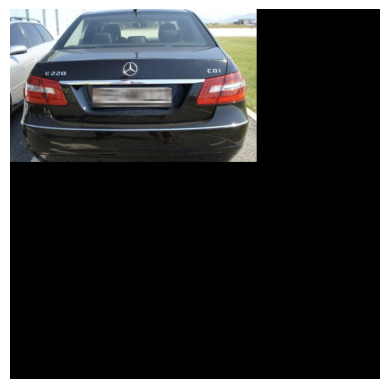

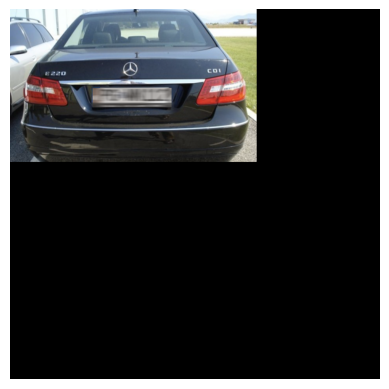

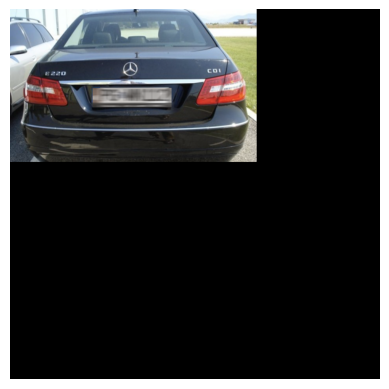

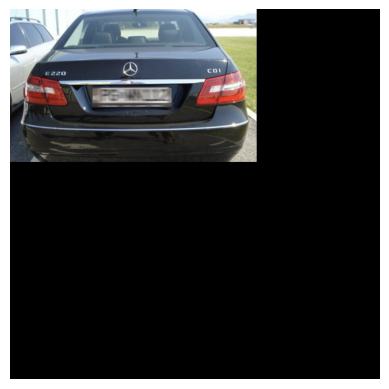

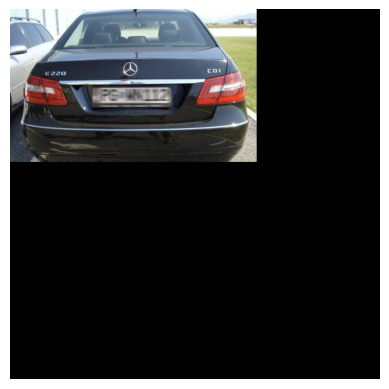

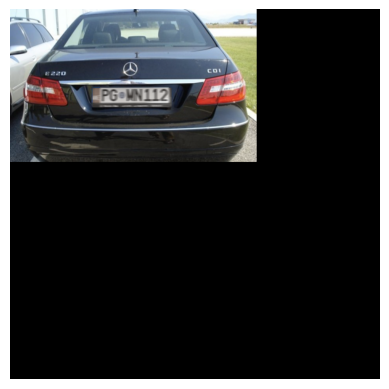

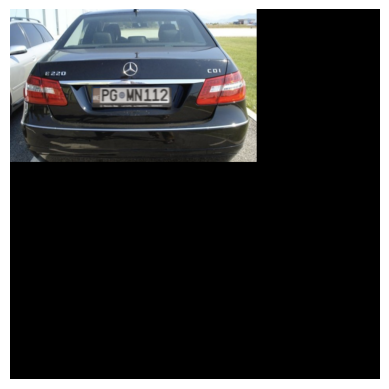

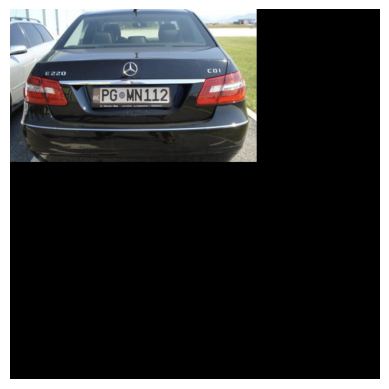

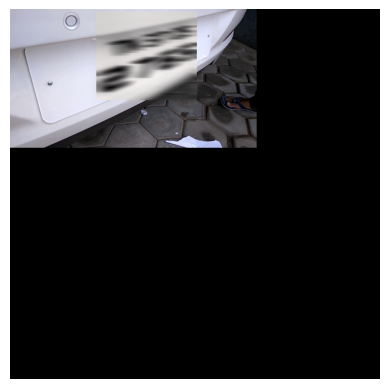

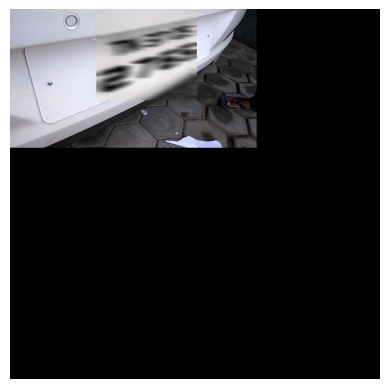

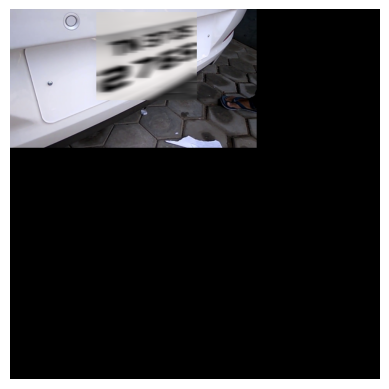

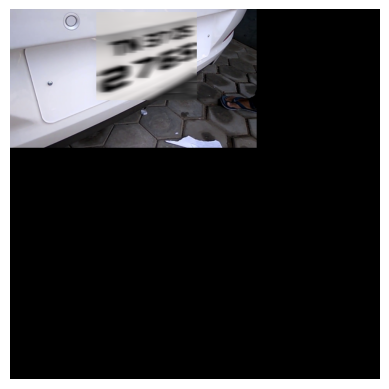

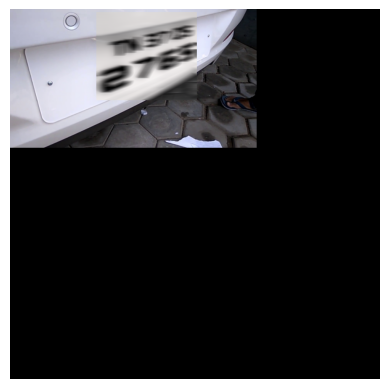

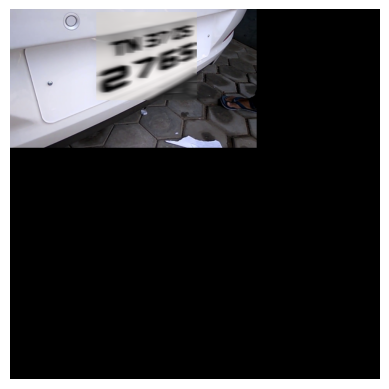

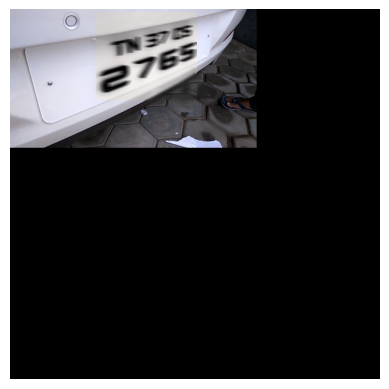

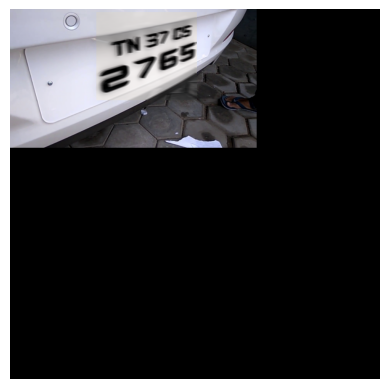

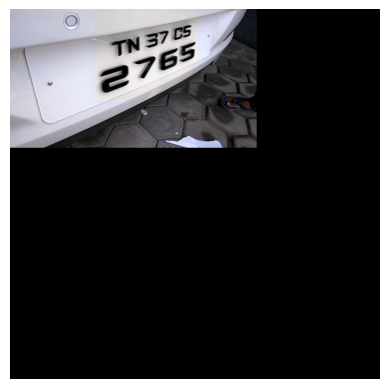

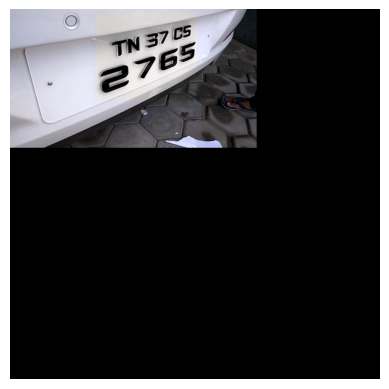

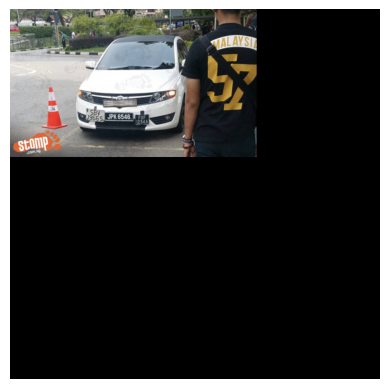

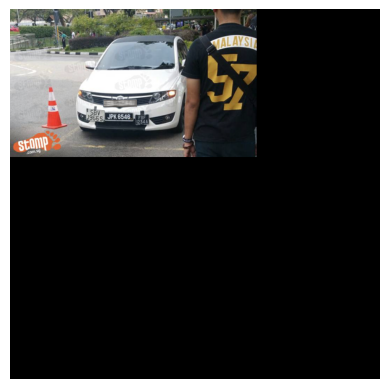

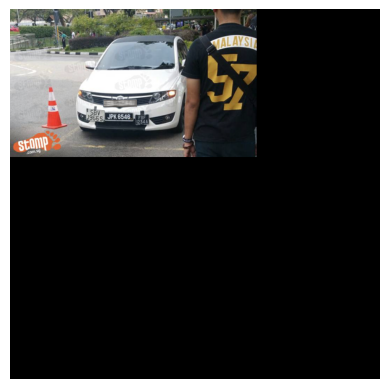

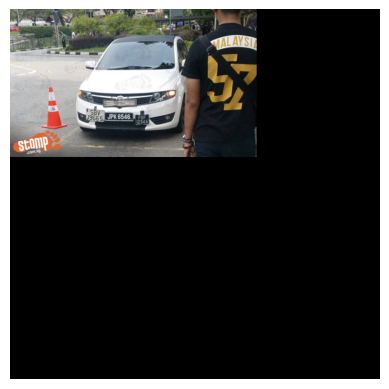

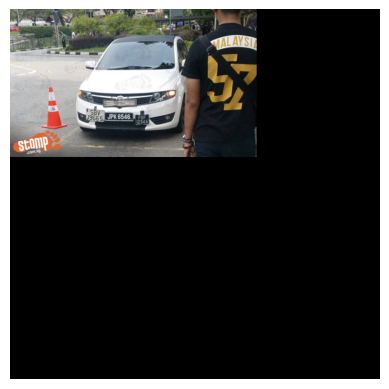

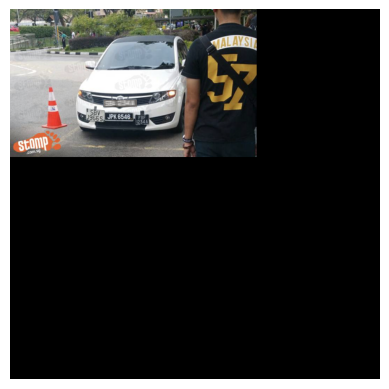

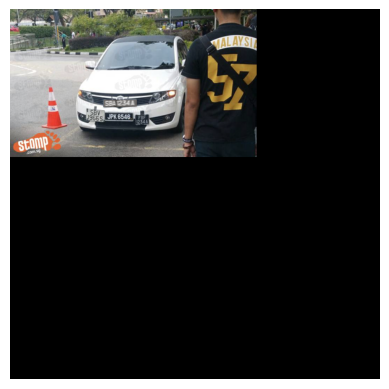

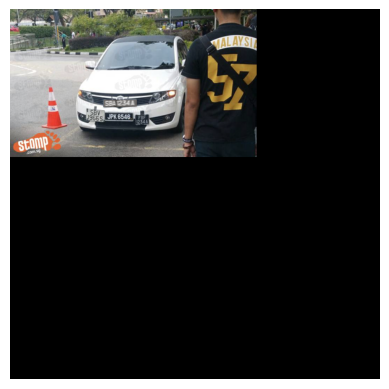

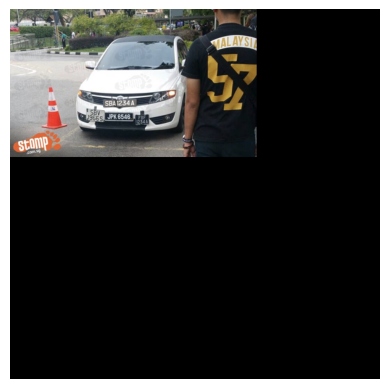

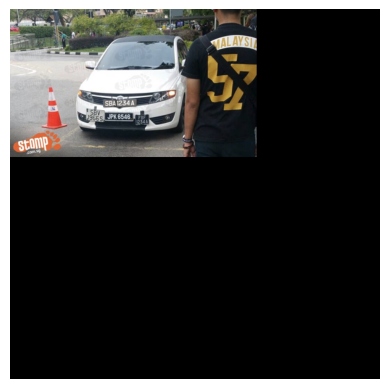

In [188]:
final_images = [0] * (3 * len(plate_images))
num_blur_levels = 10
for i in range(len(cropped_plate_images)):
    for blur_level in range(0, num_blur_levels):
        # Blur plate image
        cropped_plate_image = cropped_plate_images[i][0]
        cropped_plate_image_tensor = torch.from_numpy(cropped_plate_image)

        kernel_size = [5, to_nearest_odd((cropped_plate_image_tensor.size()[1] - cropped_plate_image_tensor.size()[1] * (blur_level) // (num_blur_levels - 1)) // 5)]
        print(kernel_size)
        sigma = 10
        blurred_plate_image = transforms.functional.gaussian_blur(cropped_plate_image_tensor, kernel_size, sigma).numpy()

        # Place blurred plate back into full image
        box = plate_images[i][1]
        final_image = plate_images[i][0].copy()
        final_image[box[1]:box[3], box[0]:box[2]] = blurred_plate_image
        final_images[i] = final_image

        # Show final blurred images
        fig, ax = plt.subplots()
        plt.axis("off")
        ax.imshow(final_image)